In [136]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView, pbfs_search, BFSVisitor, Graph, min_spanning_tree
from networkx.drawing.nx_agraph import graphviz_layout

from ic import simulate_cascade, observe_cascade, get_gvs, get_o2src_time, get_infection_time, gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.1

gvs = get_gvs(g, p, N2)
pos = graphviz_layout(gnx, root=0)

In [210]:
infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, return_tree=True)

In [211]:
def extract_tree(g, source, pred, terminals=None):
    """return a tree from source to terminals based on `pred`"""
    edges = set()

    if terminals:
        visited = set()
        for t in sorted(terminals):
            c = t
            while c != source and c not in visited:        
                visited.add(c)
                if pred[c] != -1:
                    edges.add((pred[c], c))
                    c = pred[c]
                else:
                    break
    else:
        for c, p in enumerate(pred.a):
            if p != -1:
                edges.add((c, p))
    efilt = g.new_edge_property('bool')
    for u, v in edges:
        efilt[g.edge(g.vertex(u), g.vertex(v))] = 1
    return GraphView(g, efilt=efilt)

In [212]:
class MyVisitor(BFSVisitor):

    def __init__(self, pred, dist):
        self.pred = pred
        self.dist = dist

    def discover_vertex(self, u):
        # print("-->", int(u), "has been discovered!")
        pass

    def examine_vertex(self, u):
        # print(int(u), "has been examined...")        
        pass

    def black_target(self, e):
        s, t = e.source(), e.target()
        if self.pred[t] == -1:
            self.pred[t] = s
            self.dist[e.target()] = self.dist[s] + 1
    
    def tree_edge(self, e):
        self.pred[e.target()] = int(e.source())
        self.dist[e.target()] = self.dist[e.source()] + 1

In [231]:
vis = init_visitor(g, source)

pbfs_search(g, source=root,
            visitor=vis,
            terminals=terminals,
            count_threshold=-1)
bfs_tree = extract_tree(g, source, vis.pred, terminals)

<IPython.core.display.Javascript object>


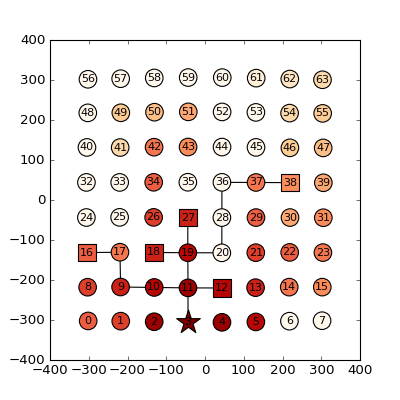

In [232]:
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax,
              edges=extract_edges(bfs_tree))

In [230]:
def init_visitor(g, root):
    dist = g.new_vertex_property("int")
    dist.set_2d_array(np.ones(g.num_vertices()) * -1)
    dist[root] = 0
    pred = g.new_vertex_property("int64_t")
    pred.set_2d_array(np.ones(g.num_vertices()) * -1)
    vis = MyVisitor(pred, dist)
    return vis

def build_closure(g, cand_source, terminals, infection_times, k=-1):
    """
    build a clojure graph in which cand_source + terminals are all connected to each other.
    the number of neighbors of each node is determined by k
    
    the larger the k, the denser the graph"""
    r2pred = {}
    edges = {}
    
    def get_edges(dist, root, terminals):     
        return ((root, t, dist[t])
                for t in terminals
                if dist[t] != -1 and t != root)
    
    # from cand_source to terminals
    vis = init_visitor(g, cand_source)
    pbfs_search(g, source=cand_source, visitor=vis, terminals=terminals, count_threshold=k)
    r2pred[cand_source] = vis.pred                
    for u, v, c in get_edges(vis.dist, cand_source, terminals):
        edges[(u, v)] = c
    
    # from terminal to other terminals
    for root in terminals:
        vis = init_visitor(g, root)
        early_terminals = [t for t in terminals
                           if infection_times[t] > infection_times[root]]
        pbfs_search(g, source=root,
                    visitor=vis,
                    terminals=early_terminals,
                    count_threshold=k)
        r2pred[root] = vis.pred
        for u, v, c in get_edges(vis.dist, root, early_terminals):
            edges[(u, v)] = c
    
    gc = Graph(directed=True)
    
    for _ in range(g.num_vertices()):
        gc.add_vertex()

    for (u, v) in edges:
        gc.add_edge(u, v)
    
    eweight = gc.new_edge_property('int')
    for e, c in edges.items():        
        eweight[e] = c
        # print(e, c)
    return gc, eweight, r2pred

In [223]:
gc, eweight, r2pred = build_closure(g, source, terminals, infection_times)

In [224]:
# get the minimum spanning arborescence
tree_efilt = min_spanning_tree(gc, eweight, root=source)
vfilt = gc.new_vertex_property('bool')
vfilt[source] = 1
for t in terminals:
    vfilt[t] = 1
tree = GraphView(gc, directed=True, efilt=tree_efilt, vfilt=vfilt)

In [225]:
# extract the edges from the original graph
edges = set()
for u, v in tree.edges():
    pred = r2pred[u]
    c = v
    while c != u and pred[c] != -1:
        edges.add((pred[c], c))
        c = pred[c]
efilt = g.new_edge_property('bool')
for e in edges:
    efilt[e] = True
original_tree = GraphView(g, directed=True, efilt=efilt)

<IPython.core.display.Javascript object>


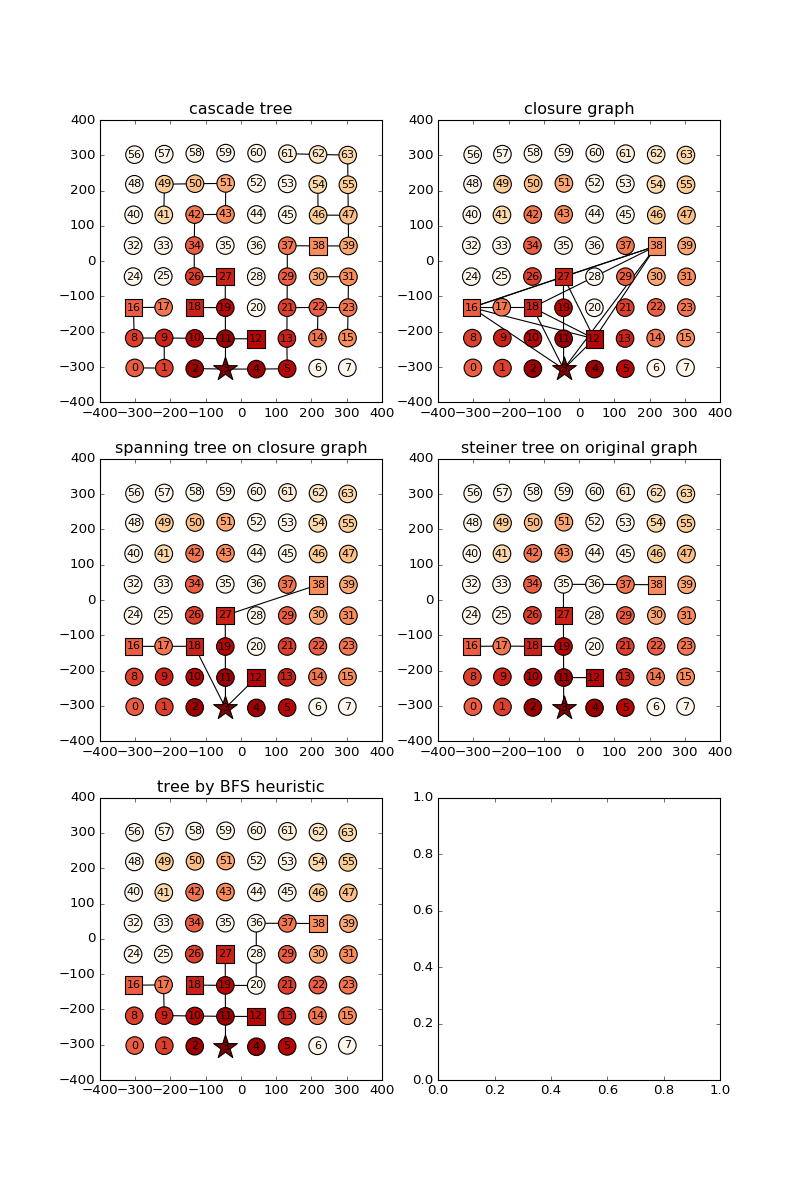

In [234]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
ax[0, 0].set_title('cascade tree')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(gc))
ax[0, 1].set_title('closure graph')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0],
              edges=extract_edges(tree))
ax[1, 0].set_title('spanning tree on closure graph')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 1],
              edges=extract_edges(original_tree))
ax[1, 1].set_title('steiner tree on original graph: m={}'.format())
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[2, 0],
              edges=extract_edges(bfs_tree))
ax[2, 0].set_title('tree by BFS heuristic: m={}'.format(bfs_tree.num_edges()))